In [1]:
%%capture
cd ..

In [2]:
import numpy as np
import pandas as pd
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from stravalib.client import Client

from src.get_strava_data import StravaAthlete
import src.data_cleanup as cln

from src.features import unpack_dict_col, curvy1, curvy2 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import recall_score, precision_score, accuracy_score, r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn import decomposition

pd.set_option('display.max_columns', 500)

In [3]:
ath_df = pd.read_csv('data/athletes.csv') 
ride_ids = pd.read_csv('data/Feldy_Bikes/ride_ids.csv')
segments_df = pd.read_csv('data/Feldy_Bikes/segments_df.csv')
efforts_df = pd.read_csv('data/Feldy_Bikes/efforts_df.csv')
seg_details_df = pd.read_csv('data/seg_details_df.csv')

In [4]:
k_eff_df = pd.read_csv('data/Karyn_Peabody/efforts_df.csv')
s_eff_df = pd.read_csv('data/Feldy_Bikes/efforts_df.csv')

In [5]:
efforts_df.shape

(67611, 8)

In [6]:
s_eff_df.shape

(67611, 8)

In [7]:
seg_details_df = unpack_dict_col(seg_details_df, 'map', 'polyline')
seg_details_df['curvy2'] = seg_details_df.polyline.apply(lambda row: curvy2(row))

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [8]:
efforts_df.head(3)

,segment_id,effort_id,name,start_date,moving_time,elapsed_time,average_heartrate,max_heartrate
0,649639,660391611,Enchanted forest descent,2012-07-28T14:21:34+00:00,0:08:13,0:08:13,NaN,NaN
1,664486,660391612,Colorow Rd Climb,2012-07-28T14:04:37+00:00,0:07:37,0:07:37,NaN,NaN
2,665783,660391613,Lower LMR to Upper LMR,2012-07-28T13:32:18+00:00,0:18:35,0:18:35,NaN,NaN


In [9]:
def clean_efforts(df):
    df.drop(['average_heartrate','max_heartrate'], axis = 1, inplace = True)
    df.dropna(inplace = True)
    df.loc[:,'moving_time'] = df.loc[:,'moving_time'].apply(cln.get_sec)
    df.loc[:,'elapsed_time'] = df.loc[:,'elapsed_time'].apply(cln.get_sec)
    df['pct_moving'] = df.moving_time / efforts_df.elapsed_time
    df = df[df.pct_moving >= .9]

In [10]:
cln.clean_efforts(efforts_df)

In [11]:
efforts_df.head(3)

,segment_id,effort_id,name,start_date,moving_time,elapsed_time,pct_moving
0,649639,660391611,Enchanted forest descent,2012-07-28T14:21:34+00:00,493,493,1.0
1,664486,660391612,Colorow Rd Climb,2012-07-28T14:04:37+00:00,457,457,1.0
2,665783,660391613,Lower LMR to Upper LMR,2012-07-28T13:32:18+00:00,1115,1115,1.0


In [13]:
cln.clean_efforts(s_eff_df)
cln.clean_efforts(k_eff_df)

In [14]:
efforts_df.shape

(67539, 7)

In [15]:
efforts_df = efforts_df[efforts_df.pct_moving >= .9]
efforts_df.shape

(59308, 7)

## Sampling with replacement but only getting small variations

In [16]:
np.mean(efforts_df.elapsed_time)

616.572823227895

Below, this samples the full set with replacement and looks for a variation of greater than 1% until it gets 5 samples. Then looks for a variation > 1.5% until it gets 5 more. I tried setting it for >2% and it took a long time to get there (so long that I gave up). In retrospect, this isn't that surprising, since there are a large number of samples and the mean wants to coverge.

In [17]:
samples = []
avg_time = np.mean(efforts_df.elapsed_time)
while len(samples) < 5:
    sample = efforts_df.sample(frac=1,replace=True)
    sample_avg = np.mean(sample.elapsed_time)
    if sample_avg/avg_time < .99:
        samples.append(sample)
    elif avg_time/sample_avg < .99:
        samples.append(sample)
while len(samples) < 10:
    sample = efforts_df.sample(frac=1,replace=True)
    sample_avg = np.mean(sample.elapsed_time)
    if sample_avg/avg_time < .985:
        samples.append(sample)
    elif avg_time/sample_avg < .985:
        samples.append(sample)

In [18]:
for sample in samples:
    print(np.mean(sample.elapsed_time))

608.6131213327038
608.3444897821541
623.8350306872597
609.5557597625952
610.1924866797059
607.1805321373171
607.2953227220611
627.3414885007081
628.0962096175896
605.3663080865988


I'm not going to work with this data for now, because I think I want to model with a sample set that has a larger variation than just a couple %. I'm looking to model large variations in segment times, not small ones.

## Splitting Data down the middle to fast and slow groups

Potential problem: distribition will not be normal.
Possible fix: bootstrap sample to get a normal distribution (not implemented)

''

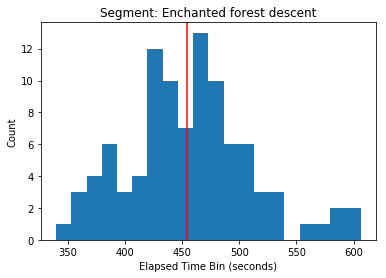

In [19]:
data = efforts_df[efforts_df.segment_id == efforts_df.segment_id.unique()[0]].elapsed_time
name = efforts_df[efforts_df.segment_id == efforts_df.segment_id.unique()[0]].name[0]

fig, ax = plt.subplots()

ax.hist(data, bins = 20)
ax.axvline(np.median(data), color = 'red')
ax.set_xlabel('Elapsed Time Bin (seconds)')
ax.set_ylabel('Count')
ax.set_title('Segment: {}'.format(name))
;

In [20]:
seg_times_df = efforts_df[['segment_id','elapsed_time']]

In [23]:
cols = ['segment_id','mean','median','std']
slow_df = pd.DataFrame(columns = cols)
fast_df = pd.DataFrame(columns = cols)

for segment in seg_times_df.segment_id.unique():

    slow = seg_times_df[(seg_times_df.segment_id == segment) & 
                        (seg_times_df.elapsed_time <= 
                         np.median(seg_times_df[seg_times_df.segment_id == segment].elapsed_time))]
    slow_dict = cln.time_stats_dict(slow)
    slow_df = slow_df.append({k:slow_dict[k] for k in cols if k in slow_dict},ignore_index=True)

    fast = seg_times_df[(seg_times_df.segment_id == segment) & 
                        (seg_times_df.elapsed_time >= 
                         np.median(seg_times_df[seg_times_df.segment_id == segment].elapsed_time))]
    fast_dict = cln.time_stats_dict(fast)
    fast_df = fast_df.append({k:fast_dict[k] for k in cols if k in fast_dict},ignore_index=True)

In [24]:
# slow_df.to_csv('data/Feldy_Bikes/slow_df.csv')
# fast_df.to_csv('data/Feldy_Bikes/fast_df.csv')

## Combining dataframes

### slow vs. fast

In [25]:
segments_df = segments_df[~segments_df.bike.isin(['CA Hardtail','Rented/Borrowed/Stolen '])]
segments_df['bike_type'] = segments_df['bike'].apply(lambda x: 'Road' if x in ['Carbon Road',
                                                                               'Road + Burley',
                                                                               'Road',
                                                                               'Fixed'] 
                                                                               else 'Mountain')
segments_by_bike_type = segments_df.groupby(['bike_type']).count().iloc[:,1].reset_index()
segments_by_bike_type.rename(columns={"ride_id": "number_of_attempts"}, inplace = True)

temp = segments_df[['segment_id','bike_type']]
temp['percent_road'] = np.where(segments_df['bike_type']=='Road',1,0)
bike_segment = temp.groupby('segment_id').mean().reset_index()
bike_segment['road_threshold'] = np.where(bike_segment.percent_road > .7, 1, np.where(bike_segment.percent_road < .3, 0, np.nan))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [26]:
seg_details_df = unpack_dict_col(seg_details_df, 'map', 'polyline')

seg_details_df['curvy2'] = seg_details_df.polyline.apply(lambda row: curvy2(row))

In [27]:
eff_seg_deats = pd.merge(efforts_df, fast_df, on = 'segment_id', how = 'inner')
eff_seg_deats = pd.merge(eff_seg_deats, slow_df, on = 'segment_id', how = 'inner', suffixes=('_fast', '_slow'))
eff_seg_deats = pd.merge(eff_seg_deats, seg_details_df, on = ['segment_id','name'], how = 'inner')
eff_seg_deats = pd.merge(eff_seg_deats, segments_df, on = 'segment_id', how = 'inner')
eff_seg_deats = pd.merge(eff_seg_deats, bike_segment, on = 'segment_id', how = 'inner')

In [28]:
eff_seg_deats.drop_duplicates(subset = ['segment_id','effort_id'], keep = 'first', inplace = True)

In [29]:
eff_seg_deats.shape

(57780, 44)

In [30]:
efforts_df.shape

(59308, 7)

In [31]:
model_df = eff_seg_deats[['distance','average_grade','elevation_low','elapsed_time',
                          'curvy2', 'road_threshold', 'mean_slow', 'median_slow', 'std_slow', 
                          'mean_fast', 'median_fast', 'std_fast']]
time_cols = ['avg_speed', 'mean_slow', 'median_slow', 'std_slow', 'mean_fast', 'median_fast', 'std_fast']
model_df.loc[:,'avg_speed'] = model_df.distance/model_df.elapsed_time
model_df.loc[:,'mean_avg_speed_fast'] = model_df.distance/model_df.mean_fast
model_df.drop_duplicates(inplace = True)
model_df.dropna(inplace = True)

X = model_df[['average_grade','elevation_low','avg_speed', 'curvy2']]
y = np.array(model_df[['mean_fast']]).T[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X.shape)
model_df.head(3)

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(45524, 4)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,distance,average_grade,elevation_low,elapsed_time,curvy2,road_threshold,mean_slow,median_slow,std_slow,mean_fast,median_fast,std_fast,avg_speed,mean_avg_speed_fast
0,1948.42,-6.7,2034.2,493,0.025596,0.0,413.979592,425.0,29.338621,497.82,485.0,38.82715,3.952170,3.913905
113,1948.42,-6.7,2034.2,563,0.025596,0.0,413.979592,425.0,29.338621,497.82,485.0,38.82715,3.460782,3.913905
226,1948.42,-6.7,2034.2,458,0.025596,0.0,413.979592,425.0,29.338621,497.82,485.0,38.82715,4.254192,3.913905


### s vs. k

In [32]:
def time_stats_dict(df):
    d = dict()
    d['segment_id'] = list(df.segment_id)[0]
    d['mean'] = np.mean(df.elapsed_time)
    d['median'] = np.median(df.elapsed_time)
    d['std'] = np.std(df.elapsed_time)
    d['count'] = df.elapsed_time.shape[0]
    return d

def efforts_stats(df):
    cols = ['segment_id','mean','median','std','count']
    output_df = pd.DataFrame(columns = cols)
    
    seg_times_df = df[['segment_id','elapsed_time']]
    
    for segment in seg_times_df.segment_id.unique():
        this_segment_df = seg_times_df[(seg_times_df.segment_id == segment) &
                                      (seg_times_df.elapsed_time < 
                                       2*np.median(seg_times_df[seg_times_df.segment_id == segment].elapsed_time))]
        this_seg_dict = time_stats_dict(this_segment_df)
        output_df = output_df.append({k:this_seg_dict[k] for k in cols if k in this_seg_dict}, ignore_index=True)
    
    return output_df

In [33]:
s_stats_df = efforts_stats(s_eff_df)

In [34]:
k_stats_df = efforts_stats(k_eff_df)

In [35]:
s_stats_df.sort_values('count', ascending=False).head(10)

,segment_id,mean,median,std,count
838,3965883.0,124.915612,118.0,30.942870,237.0
7715,20831165.0,75.793103,73.0,18.189149,232.0
19,991763.0,125.350000,123.0,26.487566,220.0
18,979002.0,135.408602,134.0,18.828734,186.0
3575,8590679.0,287.605405,284.0,34.834139,185.0
112,1042067.0,534.925714,531.0,93.711961,175.0
5640,14716360.0,469.586207,453.0,78.387859,174.0
4707,12046898.0,504.682081,500.0,88.851878,173.0
6505,17747809.0,282.017647,273.5,42.749541,170.0
2787,7431006.0,208.776471,202.0,31.377540,170.0


In [36]:
k_stats_df.sort_values('count', ascending=False).head(10)

,segment_id,mean,median,std,count
804,2387058.0,53.318841,51.0,11.766438,69.0
1799,7555201.0,342.976190,324.5,95.598239,42.0
2520,12046898.0,600.119048,601.5,74.034484,42.0
325,1042067.0,636.523810,639.5,76.135918,42.0
2268,10120694.0,949.380952,924.0,155.198483,42.0
2865,14716360.0,530.380952,524.0,56.156648,42.0
232,794216.0,1603.170732,1596.0,189.072176,41.0
62,645355.0,1720.780488,1703.0,220.055039,41.0
3149,17427654.0,1582.609756,1580.0,185.578710,41.0
65,646769.0,1592.292683,1588.0,187.799743,41.0


In [37]:
s_vs_k = pd.merge(efforts_df, k_stats_df, on = 'segment_id', how = 'inner')
s_vs_k = pd.merge(s_vs_k, s_stats_df, on = 'segment_id', how = 'inner', suffixes=('_k', '_s'))
s_vs_k = pd.merge(s_vs_k, seg_details_df, on = ['segment_id','name'], how = 'inner')
s_vs_k = pd.merge(s_vs_k, segments_df, on = 'segment_id', how = 'inner')
s_vs_k = pd.merge(s_vs_k, bike_segment, on = 'segment_id', how = 'inner')
print(s_vs_k.shape)
s_vs_k.drop_duplicates(subset = ['segment_id','effort_id'], keep = 'first', inplace = True)
print(s_vs_k.shape)

(2268291, 46)
(38779, 46)


In [38]:
s_vs_k.head(3)

,segment_id,effort_id,name,start_date,moving_time,elapsed_time,pct_moving,mean_k,median_k,std_k,count_k,mean_s,median_s,std_s,count_s,distance,average_grade,maximum_grade,elevation_high,elevation_low,total_elevation_gain,start_latitude,end_latitude,start_longitude,end_longitude,climb_category,city,state,country,effort_count,athlete_count,athlete_segment_stats,map,polyline,curvy2,ride_name,ride_id,bike,ride_distance,ride_moving_time,ride_elapsed_time,ride_elevation_gain,ride_start_time,bike_type,percent_road,road_threshold
0,649639,660391611,Enchanted forest descent,2012-07-28T14:21:34+00:00,493,493,1.000000,714.5,663.5,182.484931,12.0,499.268908,469.0,119.119931,119.0,1948.42,-6.7,407.4,2166.0,2034.2,26.2,39.717164,39.714337,-105.248621,-105.234528,0,Golden,CO,United States,48060,8108,"{'effort_count': 124, 'pr_elapsed_time': '0:05...","{'id': 's649639', 'polyline': 'gglqF|jkaSBYCSE...",gglqF|jkaSBYCSEEG{@?a@LiANe@^m@Ps@j@gARSPJBAn@...,0.025596,"11/24/2012 Golden, CO",40114272,FS Trail,8.437535,0 days 01:13:00.000000000,0 days 01:13:38.000000000,1639.763832,2012-11-24 10:20:44,Mountain,0.061947,0.0
113,649639,660391705,Enchanted forest descent,2012-07-24T12:48:25+00:00,518,563,0.920071,714.5,663.5,182.484931,12.0,499.268908,469.0,119.119931,119.0,1948.42,-6.7,407.4,2166.0,2034.2,26.2,39.717164,39.714337,-105.248621,-105.234528,0,Golden,CO,United States,48060,8108,"{'effort_count': 124, 'pr_elapsed_time': '0:05...","{'id': 's649639', 'polyline': 'gglqF|jkaSBYCSE...",gglqF|jkaSBYCSEEG{@?a@LiANe@^m@Ps@j@gARSPJBAn@...,0.025596,"11/24/2012 Golden, CO",40114272,FS Trail,8.437535,0 days 01:13:00.000000000,0 days 01:13:38.000000000,1639.763832,2012-11-24 10:20:44,Mountain,0.061947,0.0
226,649639,660411784,Enchanted forest descent,2012-05-16T12:46:16+00:00,458,458,1.000000,714.5,663.5,182.484931,12.0,499.268908,469.0,119.119931,119.0,1948.42,-6.7,407.4,2166.0,2034.2,26.2,39.717164,39.714337,-105.248621,-105.234528,0,Golden,CO,United States,48060,8108,"{'effort_count': 124, 'pr_elapsed_time': '0:05...","{'id': 's649639', 'polyline': 'gglqF|jkaSBYCSE...",gglqF|jkaSBYCSEEG{@?a@LiANe@^m@Ps@j@gARSPJBAn@...,0.025596,"11/24/2012 Golden, CO",40114272,FS Trail,8.437535,0 days 01:13:00.000000000,0 days 01:13:38.000000000,1639.763832,2012-11-24 10:20:44,Mountain,0.061947,0.0


### Standard test/train split subset

The problem with using this split is that there is leakage between the train set and the test set

In [39]:
model_df = s_vs_k[['segment_id','distance','average_grade','elevation_low','elapsed_time',
                          'curvy2', 'road_threshold', 
                          'mean_s', 'median_s', 'std_s','mean_k', 'median_k', 'std_k']].copy()
time_cols = ['avg_speed', 'mean_slow', 'median_slow', 'std_slow', 'mean_fast', 'median_fast', 'std_fast']
model_df.loc[:,'avg_speed'] = model_df.distance/model_df.elapsed_time
model_df.loc[:,'mean_avg_speed_s'] = model_df.distance/model_df.mean_s
model_df.loc[:,'mean_avg_speed_k'] = model_df.distance/model_df.mean_k
model_df.drop_duplicates(inplace = True)
model_df.dropna(inplace = True)

X = model_df[['average_grade','elevation_low','distance','elapsed_time', 'curvy2']]
y = np.array(model_df[['mean_k']]).T[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X.shape)

(29954, 5)


### Train/Test Split on segments

In [40]:
segments_train, segments_test = train_test_split(model_df.segment_id.unique(), test_size=0.2, random_state=42)

train = model_df[model_df.segment_id.isin(segments_train)]
test = model_df[model_df.segment_id.isin(segments_test)]

X_train = train[['average_grade','elevation_low','distance','elapsed_time', 'curvy2']]
X_test = test[['average_grade','elevation_low','distance','elapsed_time', 'curvy2']]
y_train = np.array(train[['mean_k']]).T[0]
y_test = np.array(test[['mean_k']]).T[0]

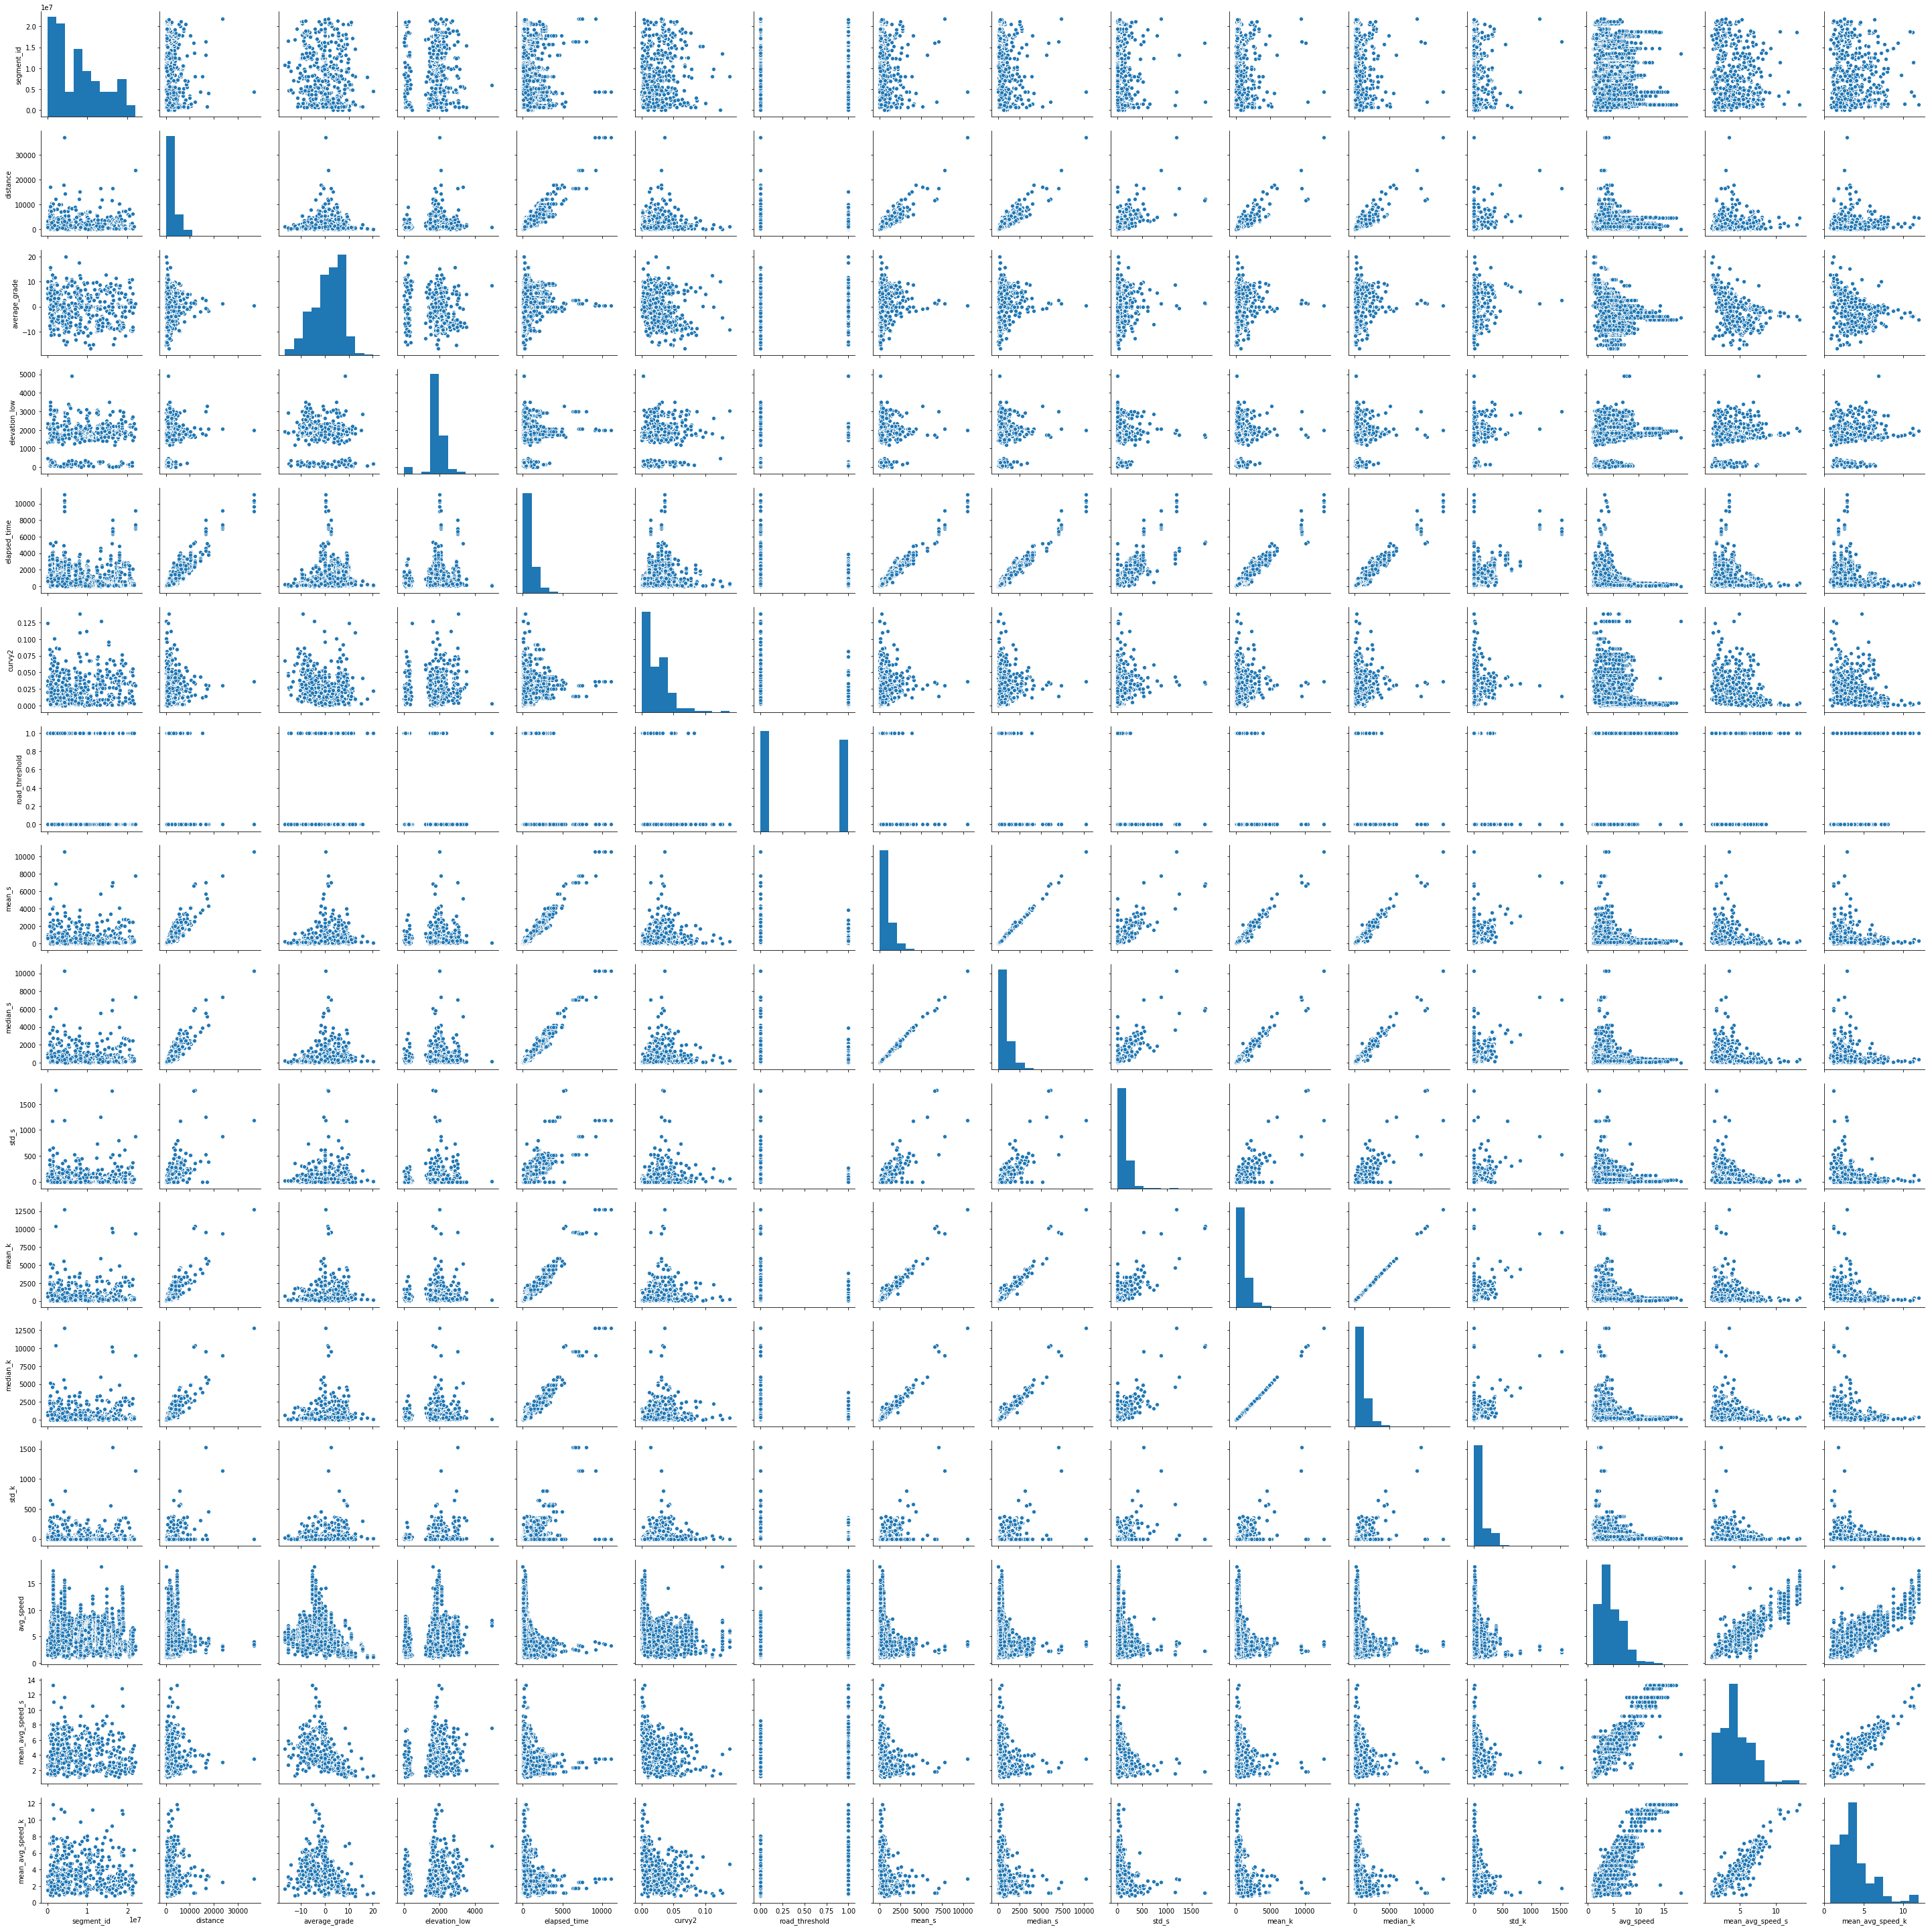

In [520]:
sns.pairplot(test)

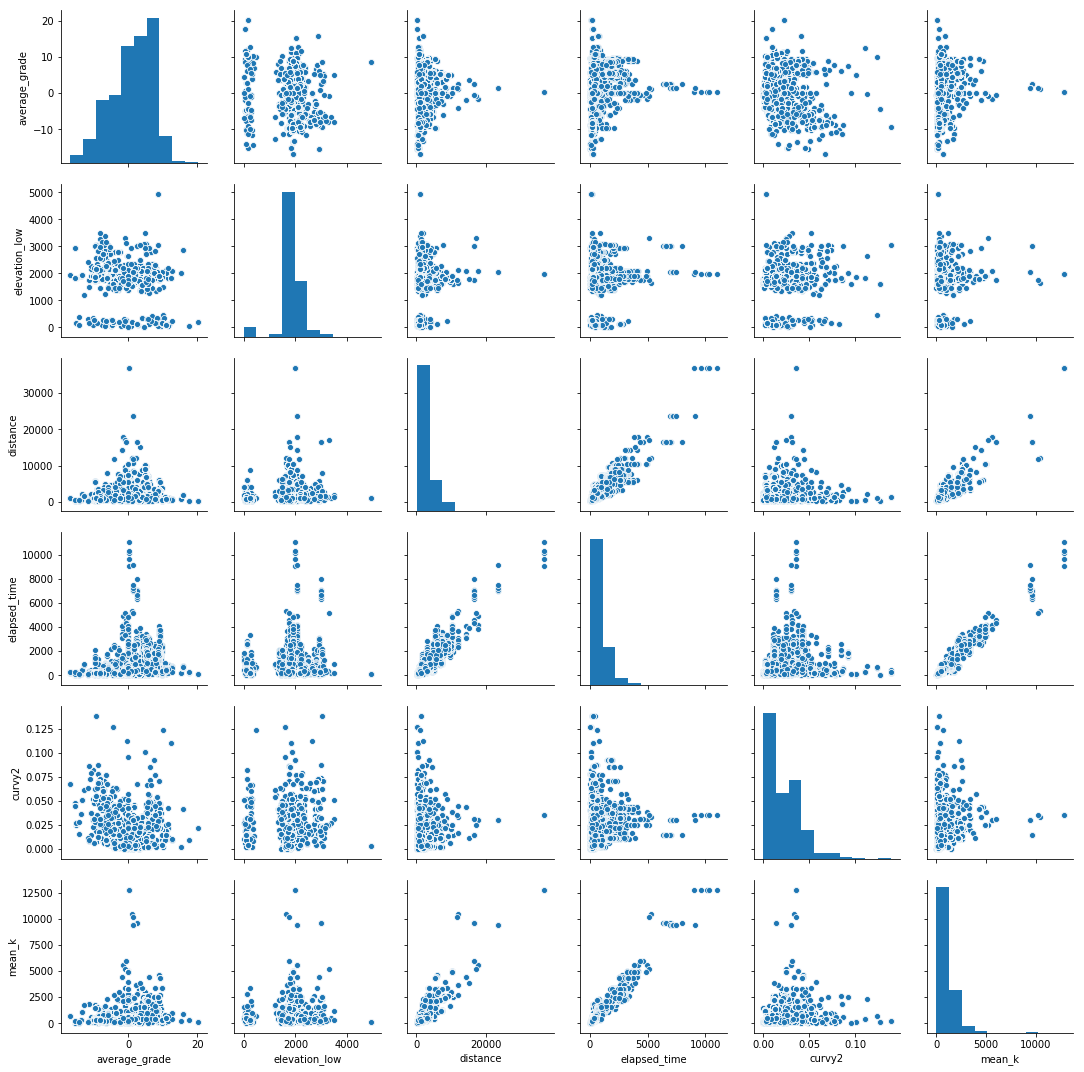

In [41]:
sns.pairplot(test[['average_grade','elevation_low','distance','elapsed_time', 'curvy2', 'mean_k']])

In [42]:
test[['average_grade','elevation_low','distance','elapsed_time', 'curvy2', 'mean_k']].corr()

,average_grade,elevation_low,distance,elapsed_time,curvy2,mean_k
average_grade,1.000000,-0.087950,0.173355,0.353613,-0.205175,0.317503
elevation_low,-0.087950,1.000000,0.042628,0.057685,0.163451,0.082069
distance,0.173355,0.042628,1.000000,0.888331,-0.060763,0.873954
elapsed_time,0.353613,0.057685,0.888331,1.000000,0.080614,0.976809
curvy2,-0.205175,0.163451,-0.060763,0.080614,1.000000,0.117419
mean_k,0.317503,0.082069,0.873954,0.976809,0.117419,1.000000


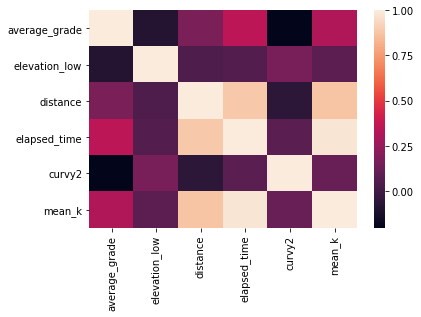

In [43]:
sns.heatmap(test[['average_grade','elevation_low','distance','elapsed_time', 'curvy2', 'mean_k']].corr())

In [47]:
def best_fit_slope_and_intercept(xs,ys):
    m = (((np.mean(xs)*np.mean(ys)) - np.mean(xs*ys)) /
         ((np.mean(xs)*np.mean(xs)) - np.mean(xs*xs)))
    
    b = np.mean(ys) - m*np.mean(xs)
    
    return m, b

In [48]:
def plot_model_performance(y_test, y_hat, target_name = '', title = ''):
    print('RMSE = {:.4f}'.format(np.sqrt(mean_squared_error(y_test, y_hat))))
    print('R^2 = {:.4f}'.format(r2_score(y_test,y_hat)))

    m, b = best_fit_slope_and_intercept(y_test,y_hat)
    regression_line = [(m*x)+b for x in y_test]

    plt.scatter(y_test, y_hat, alpha = .5, s = 5, label = None)
    plt.plot(y_test,regression_line, c = 'red', linewidth = .8, label = ('Linear Fit'))
    plt.xlabel('Actual {}'.format(target_name))
    plt.ylabel('Predicted {}'.format(target_name))
    plt.legend()
    plt.annotate('y = {0:.2f}x +{1:.2f}'.format(m, b), xy=(0.05, 0.80), xycoords='axes fraction')
    plt.annotate('R-squared = %0.2f' % r2_score(y_test,y_hat), xy=(0.05, 0.70), xycoords='axes fraction')
    plt.annotate('RMSE = %0.2f' % np.sqrt(mean_squared_error(y_test, y_hat)), xy=(0.05, 0.60), xycoords='axes fraction')
    plt.title(title)

RMSE = 367.8050
R^2 = 0.8159


Text(0, 0.5, "Karyn's average time (seconds)")

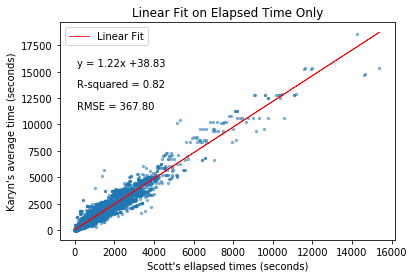

In [51]:
plot_model_performance(model_df.elapsed_time,
                       model_df.mean_k, target_name = '',
                       title = 'Linear Fit on Elapsed Time Only')
plt.xlabel('Scott\'s ellapsed times (seconds)')
plt.ylabel('Karyn\'s average time (seconds)')

## Model Plotting

In [474]:
def best_fit_slope_and_intercept(xs,ys):
    m = (((np.mean(xs)*np.mean(ys)) - np.mean(xs*ys)) /
         ((np.mean(xs)*np.mean(xs)) - np.mean(xs*xs)))
    
    b = np.mean(ys) - m*np.mean(xs)
    
    return m, b

In [540]:
def plot_model_performance(y_test, y_hat, target_name = '', title = ''):
    print('RMSE = {:.4f}'.format(np.sqrt(mean_squared_error(y_test, y_hat))))
    print('R^2 = {:.4f}'.format(r2_score(y_test,y_hat)))

    m, b = best_fit_slope_and_intercept(y_test,y_hat)
    regression_line = [(m*x)+b for x in y_test]

    plt.scatter(y_test, y_hat, alpha = .5, s = 5, label = None)
    plt.plot(y_test,regression_line, c = 'red', linewidth = .8, label = ('Linear Fit'))
    plt.xlabel('Actual {}'.format(target_name))
    plt.ylabel('Predicted {}'.format(target_name))
    plt.legend()
    plt.annotate('y = {0:.2f}x +{1:.2f}'.format(m, b), xy=(0.05, 0.80), xycoords='axes fraction')
    plt.annotate('R-squared = %0.2f' % r2_score(y_test,y_hat), xy=(0.05, 0.70), xycoords='axes fraction')
    plt.annotate('RMSE = %0.2f' % np.sqrt(mean_squared_error(y_test, y_hat)), xy=(0.05, 0.60), xycoords='axes fraction')
    plt.title(title)

In [ ]:
def plot_feature_importances(model):
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    features = list(X.columns[indices])

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("{}. {}: ({:.1%})".format(f + 1, features[f], importances[indices[f]]))


    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="lightblue", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), features, rotation = 40)
    plt.xlim([-1, X.shape[1]])
    plt.ylabel('Importance (%)')
    plt.xlabel('Feature')
    plt.show()

## Linear Model

RMSE = 225.5696
R^2 = 0.9551


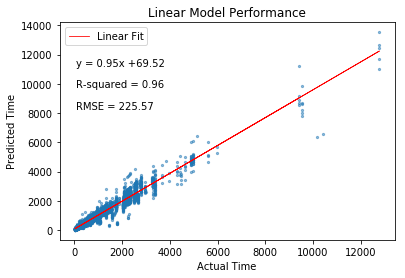

In [553]:
X_train = train[['average_grade','elevation_low','distance','elapsed_time', 'curvy2']]
X_test = test[['average_grade','elevation_low','distance','elapsed_time', 'curvy2']]
y_train = np.array(train[['mean_k']]).T[0]
y_test = np.array(test[['mean_k']]).T[0]

model = LinearRegression()
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

plot_model_performance(y_test, y_hat, 'Time', 'Linear Model Performance')


In [506]:
from sklearn import preprocessing

In [508]:
def scale_xs(df):
    x = df.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled, columns = df.columns)
    return df

RMSE = 598.3697
R^2 = 0.6843


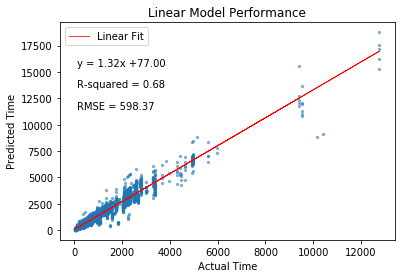

In [542]:
X_train = scale_xs(train[['average_grade','elevation_low','distance','elapsed_time', 'curvy2']])
X_test = scale_xs(test[['average_grade','elevation_low','distance','elapsed_time', 'curvy2']])
y_train = np.array(train[['mean_k']]).T[0]
y_test = np.array(test[['mean_k']]).T[0]

model = LinearRegression()
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

plot_model_performance(y_test, y_hat, 'Time', 'Linear Model Performance')

In [518]:
print('Feature: \t Coefficient:')
for i, coef in enumerate(model.coef_):
    print('{0} \t {1:.2f}'.format(X_train.columns[i], coef))

Feature: 	 Coefficient:
average_grade 	 -207.64
elevation_low 	 133.06
distance 	 -429.70
elapsed_time 	 19119.57
curvy2 	 207.22


#### St Dev Modeling

RMSE = 103.2872
R^2 = 0.2948


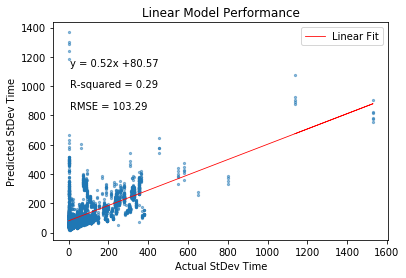

In [543]:
y_train = np.array(train[['std_k']]).T[0]
y_test = np.array(test[['std_k']]).T[0]

model = LinearRegression()
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

plot_model_performance(y_test, y_hat, 'StDev Time', 'Linear Model Performance')

#### Model based only on times

RMSE = 229.4384
R^2 = 0.9536


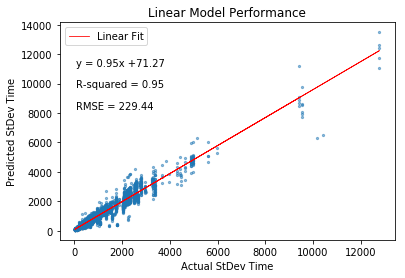

In [544]:
X_train = train[['elapsed_time']]
X_test = test[['elapsed_time']]
y_train = np.array(train[['mean_k']]).T[0]
y_test = np.array(test[['mean_k']]).T[0]
                 
model = LinearRegression()
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

plot_model_performance(y_test, y_hat, 'StDev Time', 'Linear Model Performance')

In [396]:
# need to work on this

# import statsmodels.formula.api as smf
# > reg = smf.ols('adjdep ~ adjfatal + adjsimp', data=Xtrain).fit()
# > reg.summary()

## Random Forest

RMSE = 197.6672
R^2 = 0.9656


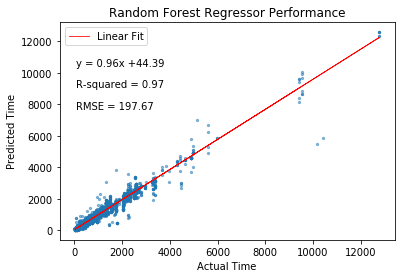

In [545]:
X_train = train[['average_grade','elevation_low','distance','elapsed_time', 'curvy2']]
X_test = test[['average_grade','elevation_low','distance','elapsed_time', 'curvy2']]
y_train = np.array(train[['mean_k']]).T[0]
y_test = np.array(test[['mean_k']]).T[0]

model = RandomForestRegressor(n_estimators=10)
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

plot_model_performance(y_test, y_hat, 'Time', 'Random Forest Regressor Performance')

Feature ranking:
1. elapsed_time: (93.8%)
2. distance: (2.9%)
3. average_grade: (1.7%)
4. elevation_low: (1.0%)
5. curvy2: (0.8%)


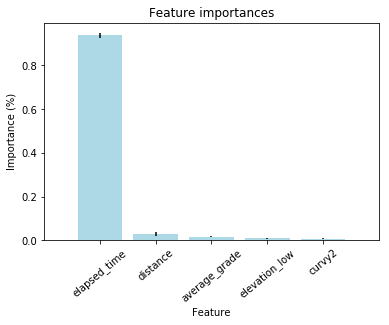

In [546]:
plot_feature_importances(model)

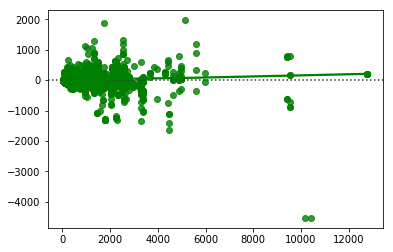

In [489]:
sns.residplot(y_test, y_hat, lowess=True, color="g")

RMSE = 81.6832
R^2 = 0.5590


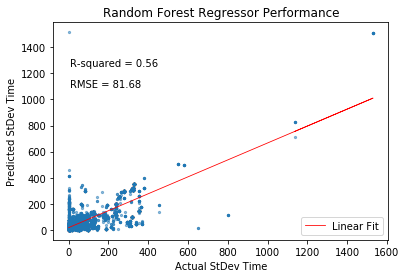

In [492]:
y_train = np.array(train[['std_k']]).T[0]
y_test = np.array(test[['std_k']]).T[0]

model = RandomForestRegressor(n_estimators=10)
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

plot_model_performance(y_test, y_hat, 'StDev Time', 'Random Forest Regressor Performance')

RMSE = 202.9647
R^2 = 0.9628


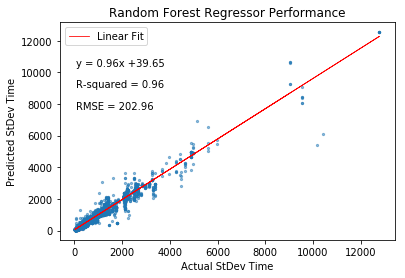

In [547]:
y_train = np.array(train[['median_k']]).T[0]
y_test = np.array(test[['median_k']]).T[0]

model = RandomForestRegressor(n_estimators=10)
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

plot_model_performance(y_test, y_hat, 'StDev Time', 'Random Forest Regressor Performance')

RMSE = 257.6417
R^2 = 0.9415


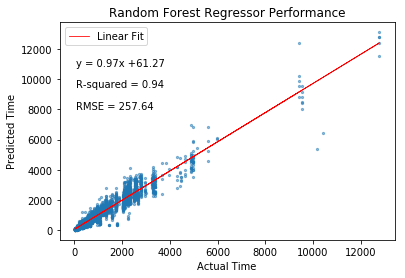

In [552]:
X_train = train[['elapsed_time']]
X_test = test[['elapsed_time']]
y_train = np.array(train[['mean_k']]).T[0]
y_test = np.array(test[['mean_k']]).T[0]

model = RandomForestRegressor(n_estimators=10)
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

plot_model_performance(y_test, y_hat, 'Time', 'Random Forest Regressor Performance')